In [ ]:

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully!")

✅ Libraries imported successfully!


In [ ]:
print("Loading dataset...")

# Try loading from local CSV files first
try:
    train_df = pd.read_csv('data/train_data.csv')
    test_df = pd.read_csv('data/test_data.csv')
    print("Loaded from saved CSV files")
    
# If not found, load from Hugging Face and save locally
except:
    print("Loading from Hugging Face...")
    from datasets import load_dataset
    
    dataset = load_dataset("papluca/language-identification")
    train_df = pd.DataFrame(dataset["train"])
    test_df = pd.DataFrame(dataset["test"])
    
    import os
    os.makedirs('data', exist_ok=True)
    train_df.to_csv('data/train_data.csv', index=False)
    test_df.to_csv('data/test_data.csv', index=False)
    print("Saved to data/ folder for faster loading next time")

# Basic dataset info
print(f"  Train samples: {len(train_df):,}")
print(f"  Test samples: {len(test_df):,}")
print(f"  Columns: {train_df.columns.tolist()}")

print(f"  Text column type: {type(train_df.iloc[0]['text'])}")
print(f"  Label column type: {type(train_df.iloc[0]['labels'])}")

print(train_df[['text', 'labels']].head(3))

Loading dataset...
✅ Loaded from saved CSV files
  Train samples: 70,000
  Test samples: 10,000
  Columns: ['labels', 'text']
  Text column type: <class 'str'>
  Label column type: <class 'str'>
                                                text labels
0  os chefes de defesa da estónia, letónia, lituâ...     pt
1  размерът на хоризонталната мрежа може да бъде ...     bg
2  很好，以前从不去评价，不知道浪费了多少积分，现在知道积分可以换钱，就要好好评价了，后来我就把...     zh


In [17]:

print("=== DATA PREPROCESSING ===")

# 1. Extract features (X) and labels (y)
X_train = train_df['text'].astype(str)  
y_train = train_df['labels'] 

X_test = test_df['text'].astype(str)
y_test = test_df['labels']

print(f"Training data: {len(X_train):,} samples")
print(f"Test data: {len(X_test):,} samples")

# 2. Show actual label values (not encoded yet)
print(f"\nLabel Format Check:")
print(f"  y_train type: {type(y_train.iloc[0])}")
print(f"  Sample y_train values: {y_train[:5].tolist()}")
print(f"  Unique labels in y_train: {y_train.unique().tolist()}")
print(f"  Number of unique labels: {len(y_train.unique())}")

# 3. Check for any issues
print("\nData Quality Check:")
print(f"  Missing texts in train: {X_train.isnull().sum()}")
print(f"  Missing labels in train: {y_train.isnull().sum()}")
print(f"  Missing texts in test: {X_test.isnull().sum()}")
print(f"  Missing labels in test: {y_test.isnull().sum()}")

# Fill any missing values
X_train = X_train.fillna('')
X_test = X_test.fillna('')
y_train = y_train.fillna('unknown')  # Temporary fill
y_test = y_test.fillna('unknown')

print("\n Data prepared for label encoding")
print("   Next: Run Label Encoding cell to convert strings to numbers")

=== DATA PREPROCESSING ===
Training data: 70,000 samples
Test data: 10,000 samples

Label Format Check:
  y_train type: <class 'str'>
  Sample y_train values: ['pt', 'bg', 'zh', 'th', 'ru']
  Unique labels in y_train: ['pt', 'bg', 'zh', 'th', 'ru', 'pl', 'ur', 'sw', 'tr', 'es', 'ar', 'it', 'hi', 'de', 'el', 'nl', 'fr', 'vi', 'en', 'ja']
  Number of unique labels: 20

Data Quality Check:
  Missing texts in train: 0
  Missing labels in train: 0
  Missing texts in test: 0
  Missing labels in test: 0

 Data prepared for label encoding
   Next: Run Label Encoding cell to convert strings to numbers


In [18]:
print("=== LABEL ENCODING ===")

from sklearn.preprocessing import LabelEncoder

# Check current label format
print(f"Current label type: {type(y_train.iloc[0]) if hasattr(y_train, 'iloc') else type(y_train[0])}")
print(f"Sample labels: {y_train[:5].tolist() if hasattr(y_train, 'tolist') else y_train[:5]}")

# Create label encoder
label_encoder = LabelEncoder()

print("\nFitting LabelEncoder on all labels...")
all_labels = pd.concat([y_train, y_test])
label_encoder.fit(all_labels)


print("Transforming labels to numeric...")
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Show the mapping
print("\n LABEL MAPPING CREATED:")
print("Index | Code | Language (Common Name)")
print("-" * 45)

# Common language names for reference
language_names = {
    'ar': 'Arabic', 'bg': 'Bulgarian', 'de': 'German', 'el': 'Greek',
    'en': 'English', 'es': 'Spanish', 'fr': 'French', 'hi': 'Hindi',
    'it': 'Italian', 'ja': 'Japanese', 'nl': 'Dutch', 'pl': 'Polish',
    'pt': 'Portuguese', 'ru': 'Russian', 'sw': 'Swahili', 'th': 'Thai',
    'tr': 'Turkish', 'ur': 'Urdu', 'vi': 'Vietnamese', 'zh': 'Chinese'
}

for i, code in enumerate(label_encoder.classes_):
    name = language_names.get(code, 'Unknown')
    print(f"  {i:2d}  |  {code:2s}  |  {name}")

# Update variables (CRITICAL: replace old string labels)
y_train = y_train_encoded
y_test = y_test_encoded

print(f"\nENCODED LABEL STATISTICS:")
print(f"  Training labels shape: {y_train.shape}")
print(f"  Test labels shape: {y_test.shape}")
print(f"  Unique labels in train: {np.unique(y_train)}")
print(f"  Unique labels in test: {np.unique(y_test)}")

# Check class distribution
print("\nCLASS DISTRIBUTION (Training):")
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    code = label_encoder.inverse_transform([label])[0]
    print(f"  Label {label:2d} ({code}): {count:4d} samples")

print("\nCLASS DISTRIBUTION (Test):")
unique, counts = np.unique(y_test, return_counts=True)
for label, count in zip(unique, counts):
    code = label_encoder.inverse_transform([label])[0]
    print(f"  Label {label:2d} ({code}): {count:4d} samples")

import joblib
import os
os.makedirs('models', exist_ok=True)
joblib.dump(label_encoder, 'models/label_encoder.pkl')
print("\nLabel encoder saved to: models/label_encoder.pkl")

print("\nLabel encoding complete! Ready for TF-IDF.")

=== LABEL ENCODING ===
Current label type: <class 'str'>
Sample labels: ['pt', 'bg', 'zh', 'th', 'ru']

Fitting LabelEncoder on all labels...
Transforming labels to numeric...

 LABEL MAPPING CREATED:
Index | Code | Language (Common Name)
---------------------------------------------
   0  |  ar  |  Arabic
   1  |  bg  |  Bulgarian
   2  |  de  |  German
   3  |  el  |  Greek
   4  |  en  |  English
   5  |  es  |  Spanish
   6  |  fr  |  French
   7  |  hi  |  Hindi
   8  |  it  |  Italian
   9  |  ja  |  Japanese
  10  |  nl  |  Dutch
  11  |  pl  |  Polish
  12  |  pt  |  Portuguese
  13  |  ru  |  Russian
  14  |  sw  |  Swahili
  15  |  th  |  Thai
  16  |  tr  |  Turkish
  17  |  ur  |  Urdu
  18  |  vi  |  Vietnamese
  19  |  zh  |  Chinese

ENCODED LABEL STATISTICS:
  Training labels shape: (70000,)
  Test labels shape: (10000,)
  Unique labels in train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
  Unique labels in test: [ 0  1  2  3  4  5  6  7  8  9 10 11 1

In [19]:

print("=== TF-IDF VECTORIZATION ===")

# Configure TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=10000,       
    ngram_range=(1, 2),       
    min_df=5,                 
    max_df=0.7,               
    lowercase=True,           
    stop_words=None,          
    analyzer='word'           
)

# Fit and transform the training data, transform the test data
print("Fitting TF-IDF on training data...")
X_train_tfidf = tfidf.fit_transform(X_train)
print("Transforming test data...")
X_test_tfidf = tfidf.transform(X_test)

print(f"  Training shape: {X_train_tfidf.shape}")
print(f"  Test shape: {X_test_tfidf.shape}")
print(f"  Vocabulary size: {len(tfidf.vocabulary_):,} words")

# Display some feature names
print("\nSample feature names (words):")
feature_names = tfidf.get_feature_names_out()
print(f"  First 10: {feature_names[:10]}")
print(f"  Last 10: {feature_names[-10:]}")
print(f"  Random 10: {np.random.choice(feature_names, 10)}")

=== TF-IDF VECTORIZATION ===
Fitting TF-IDF on training data...
Transforming test data...
  Training shape: (70000, 10000)
  Test shape: (10000, 10000)
  Vocabulary size: 10,000 words

Sample feature names (words):
  First 10: ['00' '000' '000 000' '01' '04' '10' '10 000' '100' '100 000' '11']
  Last 10: ['しかし' 'ただ' 'でも' 'また' '不错' '但是' '很喜欢' '很好' '残念です' '追記']
  Random 10: ['dünya' 'contro' 'mwingine' 'und man' 'zona' 'کی گئی' 'novo' 'plan'
 'είναι ένα' 'aver']


In [20]:

print("=== LOGISTIC REGRESSION MODEL ===")


#   Initialize model with parameters for multi-class classification
model = LogisticRegression(
    C=1.0,                    
    max_iter=1000,           
    solver='lbfgs',                  
    class_weight='balanced',  
    random_state=42          
)

# Train the model
print("Training in progress...")
model.fit(X_train_tfidf, y_train)

print("Model training complete!")
print(f"  Number of iterations: {model.n_iter_[0]}")
print(f"  Classes learned: {model.classes_}")
print(f"  Model coefficients shape: {model.coef_.shape}")

=== LOGISTIC REGRESSION MODEL ===
Training in progress...
Model training complete!
  Number of iterations: 78
  Classes learned: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
  Model coefficients shape: (20, 10000)


In [25]:
print("=== MODEL EVALUATION ===")

# Make predictions
print("Making predictions...")
y_train_pred = model.predict(X_train_tfidf)
y_test_pred = model.predict(X_test_tfidf)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Calculate F1 scores 
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"\n PERFORMANCE METRICS:")
print(f"  Training Accuracy: {train_accuracy:.2%}")
print(f"  Test Accuracy:     {test_accuracy:.2%}")
print(f"  Training F1 Score: {train_f1:.2%}")
print(f"  Test F1 Score:     {test_f1:.2%}")

# Check for overfitting
overfit_gap = train_accuracy - test_accuracy
print(f"\n Overfitting Analysis:")
print(f"  Accuracy gap (train - test): {overfit_gap:.2%}")
if overfit_gap > 0.1:
    print("    Warning: Potential overfitting (gap > 10%)")
elif overfit_gap > 0.05:
    print("    Moderate overfitting (gap 5-10%)")
else:
    print("   Good generalization (gap < 5%)")

=== MODEL EVALUATION ===
Making predictions...

 PERFORMANCE METRICS:
  Training Accuracy: 92.74%
  Test Accuracy:     90.69%
  Training F1 Score: 92.22%
  Test F1 Score:     90.56%

 Overfitting Analysis:
  Accuracy gap (train - test): 2.05%
   Good generalization (gap < 5%)


In [23]:
print("=== DETAILED PERFORMANCE ===")

print("\n Classification Report(Test Set):")

# Convert numeric predictions back to string labels for readable report
y_test_strings = label_encoder.inverse_transform(y_test)
y_test_pred_strings = label_encoder.inverse_transform(y_test_pred)

report = classification_report(y_test_strings, y_test_pred_strings, digits=3)
print(report)

print("\nPer-Class Accuracy (with Language Names):")
unique_labels = np.unique(y_test)
for label in unique_labels[:15]:  
    mask = y_test == label
    if mask.sum() > 0:
        acc = accuracy_score(y_test[mask], y_test_pred[mask])
        lang_code = label_encoder.inverse_transform([label])[0]
        lang_name = language_names.get(lang_code, 'Unknown')
        print(f"  {lang_code} ({lang_name}): {acc:.2%} ({mask.sum()} samples)")

=== DETAILED PERFORMANCE ===

 Classification Report(Test Set):
              precision    recall  f1-score   support

          ar      1.000     0.926     0.962       500
          bg      0.984     0.974     0.979       500
          de      1.000     0.984     0.992       500
          el      1.000     0.986     0.993       500
          en      0.990     0.988     0.989       500
          es      0.984     0.990     0.987       500
          fr      0.990     0.994     0.992       500
          hi      1.000     0.946     0.972       500
          it      0.988     0.960     0.974       500
          ja      0.719     0.092     0.163       500
          nl      0.998     0.964     0.981       500
          pl      0.957     0.884     0.919       500
          pt      0.969     0.952     0.961       500
          ru      0.989     0.932     0.960       500
          sw      0.990     0.968     0.979       500
          th      1.000     0.718     0.836       500
          tr     

=== CONFUSION ANALYSIS ===


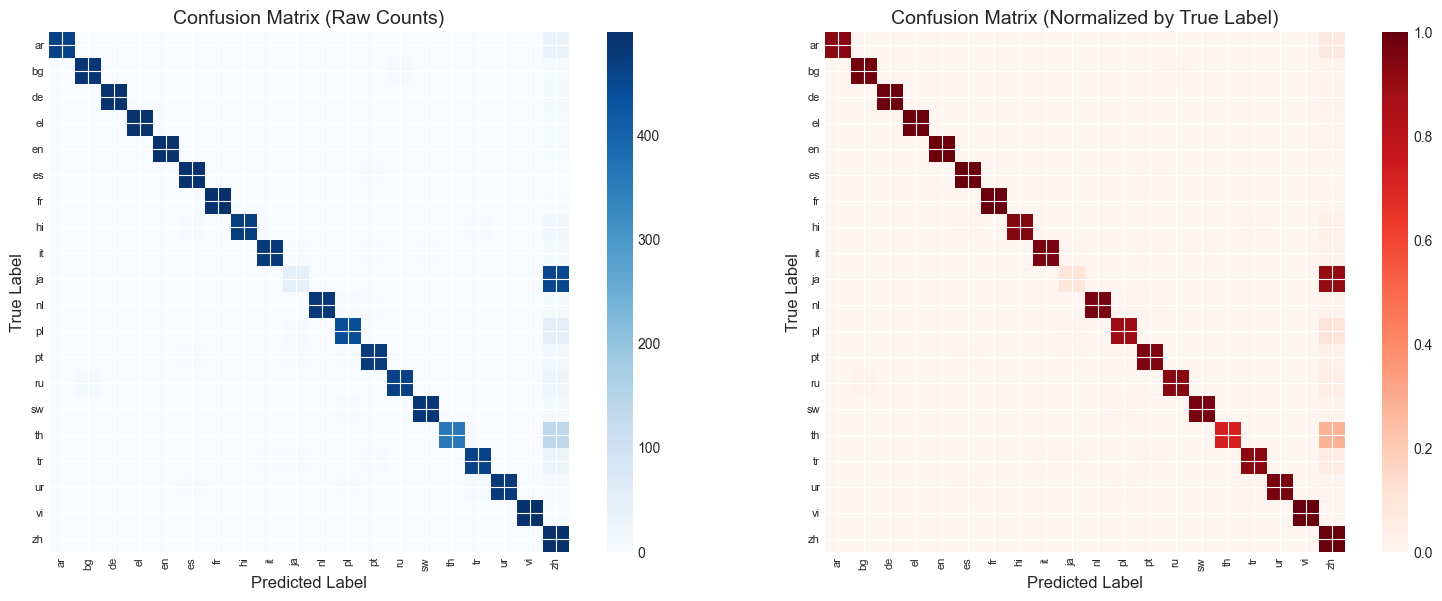


 Most Confused Language Pairs:
  Top confused pairs:
    ja (Japanese) → zh (Chinese): 453 samples
    th (Thai) → zh (Chinese): 138 samples
    pl (Polish) → zh (Chinese): 50 samples
    ar (Arabic) → zh (Chinese): 35 samples
    tr (Turkish) → zh (Chinese): 26 samples
    ru (Russian) → zh (Chinese): 24 samples
    hi (Hindi) → zh (Chinese): 17 samples
    pt (Portuguese) → zh (Chinese): 14 samples
    it (Italian) → zh (Chinese): 11 samples


In [24]:

print("=== CONFUSION ANALYSIS ===")

# Create confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot with actual labels
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Get label names for ticks
label_codes = label_encoder.classes_

# Plot 1: Standard confusion matrix
im1 = axes[0].imshow(cm, interpolation='nearest', cmap='Blues')
axes[0].set_title('Confusion Matrix (Raw Counts)', fontsize=14)
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xticks(range(len(label_codes)))
axes[0].set_yticks(range(len(label_codes)))
axes[0].set_xticklabels(label_codes, rotation=90, fontsize=8)
axes[0].set_yticklabels(label_codes, fontsize=8)
plt.colorbar(im1, ax=axes[0])

# Plot 2: Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.nan_to_num(cm_normalized)

im2 = axes[1].imshow(cm_normalized, interpolation='nearest', cmap='Reds', vmin=0, vmax=1)
axes[1].set_title('Confusion Matrix (Normalized by True Label)', fontsize=14)
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xticks(range(len(label_codes)))
axes[1].set_yticks(range(len(label_codes)))
axes[1].set_xticklabels(label_codes, rotation=90, fontsize=8)
axes[1].set_yticklabels(label_codes, fontsize=8)
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

# Find most confused pairs WITH ACTUAL LABELS
print("\n Most Confused Language Pairs:")
n_classes = cm.shape[0]
confusion_pairs = []

for i in range(n_classes):
    for j in range(n_classes):
        if i != j and cm[i, j] > 10:  # Only show confusions > 10 samples
            true_lang = label_encoder.inverse_transform([i])[0]
            pred_lang = label_encoder.inverse_transform([j])[0]
            true_name = language_names.get(true_lang, true_lang)
            pred_name = language_names.get(pred_lang, pred_lang)
            confusion_pairs.append((true_lang, pred_lang, cm[i, j], true_name, pred_name))

# Sort by confusion count
confusion_pairs.sort(key=lambda x: x[2], reverse=True)

print("  Top confused pairs:")
for true_code, pred_code, count, true_name, pred_name in confusion_pairs[:10]:
    print(f"    {true_code} ({true_name}) → {pred_code} ({pred_name}): {count} samples")

In [26]:
print("=== SAVING MODEL & RESULTS ===")

import os
import joblib
import json
from datetime import datetime

# Create models directory

os.makedirs('results', exist_ok=True)

# 1. Save the trained model
model_path = 'models/baseline_tfidf_lr.pkl'
joblib.dump(model, model_path)
print(f" Model saved to: {model_path}")

# 2. Save the TF-IDF vectorizer
tfidf_path = 'models/tfidf_vectorizer.pkl'
joblib.dump(tfidf, tfidf_path)
print(f" TF-IDF vectorizer saved to: {tfidf_path}")

# 3. Save results to JSON
results = {
    'model_type': 'TF-IDF + Logistic Regression',
    'timestamp': datetime.now().isoformat(),
    'parameters': {
        'tfidf_max_features': 10000,
        'tfidf_ngram_range': [1, 2],
        'tfidf_min_df': 5,
        'tfidf_max_df': 0.7,
        'lr_C': 1.0,
        'lr_max_iter': 1000,
        'lr_solver': 'lbfgs',
        'lr_class_weight': 'balanced'
    },
    'performance': {
        'train_accuracy': float(train_accuracy),
        'test_accuracy': float(test_accuracy),
        'train_f1': float(train_f1),
        'test_f1': float(test_f1),
        'overfitting_gap': float(train_accuracy - test_accuracy)
    },
    'data_info': {
        'train_samples': int(len(X_train)),
        'test_samples': int(len(X_test)),
        'num_classes': int(len(np.unique(y_train))),
        'vocabulary_size': int(len(tfidf.vocabulary_))
    }
}

results_path = 'results/baseline_results.json'
with open(results_path, 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=2)
print(f" Results saved to: {results_path}")

# 4. Create a simple test function for later use
test_code = '''
def predict_language(text):
    """Predict language using baseline model."""
    import joblib
    import numpy as np
    
    # Load model and vectorizer
    model = joblib.load('models/baseline_tfidf_lr.pkl')
    tfidf = joblib.load('models/tfidf_vectorizer.pkl')
    
    # Transform and predict
    text_vectorized = tfidf.transform([text])
    prediction = model.predict(text_vectorized)[0]
    probability = model.predict_proba(text_vectorized)[0]
    
    return {
        'predicted_language': int(prediction),
        'confidence': float(np.max(probability)),
        'all_probabilities': probability.tolist()
    }

# Example usage:
# result = predict_language("Hello, how are you?")
# print(f"Predicted: {result['predicted_language']} with {result['confidence']:.2%} confidence")
'''

with open('models/baseline_predict.py', 'w', encoding='utf-8') as f:
    f.write(test_code)
print(f" Prediction script saved to: models/baseline_predict.py")

=== SAVING MODEL & RESULTS ===
 Model saved to: models/baseline_tfidf_lr.pkl
 TF-IDF vectorizer saved to: models/tfidf_vectorizer.pkl
 Results saved to: results/baseline_results.json
 Prediction script saved to: models/baseline_predict.py
